# <font color=Crimson size=6 face="宋体" align="center">k均值聚类算法（k-means clustering algorithm）</font>
--------------

# <font color=black size=5 face="宋体" align="center">k均值聚类算法是</font><font color=Crimson size=5 face="宋体" align="center">无监督</font><font color=black size=5 face="宋体" align="center">的</font><font color=Crimson size=5 face="宋体" align="center">聚类</font><font color=black size=5 face="宋体" align="center">算法</font>
--------------
<font color=black size=4 face="微软雅黑" align="center">聚类、无监督：样本无标签</font>

<font color=black size=4 face="微软雅黑" align="center">分类、有监督：样本有标签</font>

算法步骤

1.初始化 K 个聚类中心

2.按最小距离原则将其余样本分配到K个聚类中心中的某一个

3.更新各个聚类中心

4.如果中心没改变则算法收敛退出，否则跳到第2步循环执行

<font color=black size=4 face="微软雅黑" align="center">接下来以二维模拟样本为例，使用Kmeans算法聚类</font>

In [1]:
from __future__ import print_function

import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive, Layout
import pylab

import os

from dataset_producer import Dataset, rand_uniform_data
from kmeans_algo import kmeans, randCentroids


# 导入原始数据
## 看看不同的数据集，或者生成自己的数据吧
#### 注：生成的随机数据集存入tempSet.txt
TODO:
添加样本点更多、数据分布不同的数据集

In [2]:
#数据集存放位置
DATA_DIR = "testdata/"
all_data_path = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        all_data_path.append(os.path.join(root, file))

#可交互文件选择模块
iw_filename = widgets.Dropdown(options=all_data_path, description='选择数据集:')
w_gen_button = widgets.Button(description='生成随机数据集')
w_output = widgets.Output(layout=Layout(flex='2 1 0%', width='auto'))
w_draw_output = widgets.Output(layout=Layout(flex='3 1 0%', width='auto'))
w_rand_size = widgets.IntSlider(value=100, min=10, max=2000, description='生成数据个数')

new_dataset = Dataset()


def gen_rand_data(b):
    """
    点击按钮生成随机数据集，写入testdata，并展示
    :param b:按钮控件
    :return:
    """
    %matplotlib inline
    global new_dataset
    new_dataset = rand_uniform_data(n=w_rand_size.value, d=2)
    with w_output:
        w_output.clear_output(wait=True)
        display(new_dataset.data)
    with w_draw_output:
        w_draw_output.clear_output(wait=True)
        new_dataset.draw_2D_data()
        plt.show()  #不加这个会导致多张图片生成


def choose_show(filename):
    """
    选择原有数据集，展示原始数据
    :param filename: 文件路径
    :return:
    """
    %matplotlib inline
    global new_dataset

    new_dataset = Dataset(path=filename)
    with w_output:
        w_output.clear_output(wait=True)
        display(new_dataset.data)
    with w_draw_output:
        w_draw_output.clear_output(wait=True)
        new_dataset.draw_2D_data()
        plt.show()


w_gen_button.on_click(gen_rand_data)
a = interactive(choose_show, filename=all_data_path)
items=[w_draw_output, w_output]
# 控件排版
display(w_rand_size, w_gen_button, a)
display(widgets.HBox(items))

IntSlider(value=100, description='生成数据个数', max=2000, min=10)

Button(description='生成随机数据集', style=ButtonStyle())

interactive(children=(Dropdown(description='filename', options=('testdata/barsSet.txt', 'testdata/blobSet.txt'…

# Kmeans算法部分
## 初始化K个聚类中心$M_1 (0),M_2 (0),…,M_K (0)$
### 鼠标添加你的聚类中心，或者随机生成K个中心

In [3]:
%matplotlib notebook
#等待载入完成
time.sleep(4)

IntSlider(value=0, description='K', max=10)

Button(description='生成中心点', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>


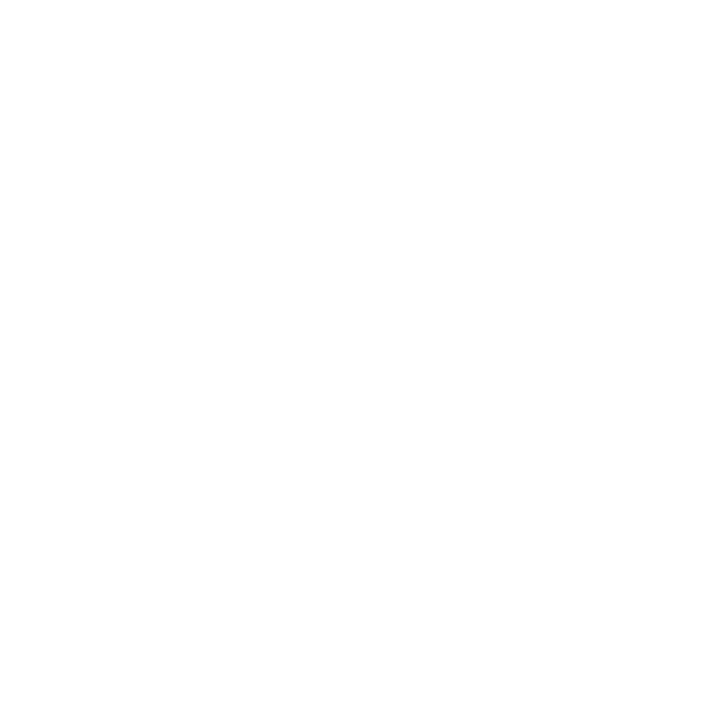

In [4]:
centroids: np.ndarray = None

w_centroids_button = widgets.Button(description='生成中心点')
K_widget = widgets.IntSlider(value=0, min=0, max=10, step=1, description='K')
centroid_output = widgets.Output()
def centroids_show(b):
    %matplotlib notebook
    global centroids
    centroids = randCentroids(x=new_dataset.numpydata, k=K_widget.value)
    
    def onclick(event):
        """
        matplotlib图片点击事件
        """
        global centroids
        ax.plot(event.xdata, event.ydata, 'ro', linewidth=20)
        #全局变量记录下鼠标点击的位置
        centroids = np.append(centroids, [[event.xdata, event.ydata]], axis=0)
        tx = 'xdata=%f, ydata=%f, k=%d' % (event.xdata, event.ydata, centroids.shape[0])
        text.set_text(tx)
    
    with centroid_output:
        centroid_output.clear_output()
        print("中心点的坐标是\n", centroids)    
        fig, ax = new_dataset.draw_2D_data()
        ax.scatter(centroids[:, 0], centroids[:, 1], c='r')
        text = fig.text(0, 0.9, "", va="bottom", ha="left", fontsize=17)
        cid = fig.canvas.mpl_connect('button_press_event', onclick)


w_centroids_button.on_click(centroids_show)
display(K_widget, w_centroids_button, centroid_output)

# 聚类结果

In [5]:
%matplotlib inline

info_list = kmeans(data=new_dataset.numpydata, centroids=centroids)

fig_out,clstAss_out=widgets.Output(),widgets.Output()

legend_handles=[]
plt.figure(figsize=(8,8))
for i in range(centroids.shape[0]):
    clst = new_dataset.numpydata[np.where(info_list[-1].clstAss[:, 0].ravel() == i)]
    tmp=plt.scatter(clst[:, 0], clst[:, 1], marker='x', c=list(TABLEAU_COLORS)[i])
    legend_handles.append(tmp)
    plt.scatter(info_list[-1].cent[i, 0], info_list[-1].cent[i, 1],
                marker='o', c=list(TABLEAU_COLORS)[i],linewidths=10)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(handles=legend_handles,labels=range(centroids.shape[0]))
plt.title("result")
with fig_out:
    plt.show()
with clstAss_out:
    print("x\ty\tclass\tSE")
    for i in range(new_dataset.size):
        print("%f\t%f\t%d\t%f"%(new_dataset.numpydata[i][0],new_dataset.numpydata[i][1],info_list[-1].clstAss[i][0],info_list[-1].clstAss[i][1]))
widgets.HBox([fig_out,clstAss_out])

C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\DELL\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


# 分步观察Kmeans算法的运行过程

In [6]:
def show_j(n):
    j_i=[0]*centroids.shape[0]
    for i in range(centroids.shape[0]):
        #找出第i类样本的下标
        clst_idx = np.where(info_list[n].clstAss[:, 0].ravel() == i)
        #对应第i类的距离平方
        clst_se=info_list[n].clstAss[:, 1][clst_idx]
        j_i[i]=sum(clst_se)
    j=sum(j_i)
    with j_out:
        j_out.clear_output()
        for i in range(centroids.shape[0]):
            print("J%d=%f"%(i,j_i[i]))
        print("J=%f" % j)

def processing_display(n):
    n -= 1
    process = '分配样本' if n % 2 == 0 else '重新计算中心'
    plt.figure(figsize=(8,8))
    legend_handles=[]
    #对于每个类别分别绘制
    for i in range(centroids.shape[0]):
        #找出第i类样本的下标
        clst_idx = np.where(info_list[n].clstAss[:, 0].ravel() == i)
        #获取i类数据
        clst_coordinate = new_dataset.numpydata[clst_idx]
        #绘制第i个类别的样本
        tmp=plt.scatter(clst_coordinate[:, 0], clst_coordinate[:, 1], marker='x', c=list(TABLEAU_COLORS)[i])
        legend_handles.append(tmp)
        #绘制第i个类别的中心
        plt.scatter(info_list[n].cent[i, 0], info_list[n].cent[i, 1],
                    marker='o', c=list(TABLEAU_COLORS)[i],linewidths=10)
        #绘制第i个中心的轨迹
        x=[info_list[j].cent[i,0] for j in range(n+1)]
        y=[info_list[j].cent[i,1] for j in range(n+1)]
        plt.plot(x,y,"b-o",c=list(TABLEAU_COLORS)[i])
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(handles=legend_handles,labels=range(centroids.shape[0]))
    plt.rcParams['font.sans-serif'] = ['KaiTi']  #中文标题
    plt.rcParams['axes.unicode_minus'] = False  #坐标负号不显示bug
    plt.title("第%d轮迭代，%s的结果" % ((n // 2 + 1), process), fontsize=17)
    with media_out:
        media_out.clear_output()
        plt.show()

j_out=widgets.Output()
media_out = widgets.Output()
n_widget = widgets.IntSlider(min=1, max=len(info_list), description='',
                             continuous_update=False)
play_widget = widgets.Play(interval=5000,value=1,min=1,max=len(info_list),step=1,
                           description="Press play",disabled=False)

widgets.jslink((play_widget, 'value'), (n_widget, 'value'))
# display(play_widget, b, media_out,j_out)

Link(source=(Play(value=1, description='Press play', interval=5000, max=36, min=1), 'value'), target=(IntSlide…

### 中心的移动 $$M_j(k+1)=\frac{1}{|\omega_j|}\displaystyle \sum^{}_{\textbf x \in \omega_j}{\textbf x}\qquad,j=1,2,...,K$$
### 样本的分配 $$若j=\mathop{\arg\min}\limits_{i\in[1,K]}\{||\textbf x-M_j(k)||\}，则\textbf x\in\omega_j$$
### 误差平方和 $$J=\displaystyle \sum^{K}_{j=1}{J_j}=\displaystyle \sum^{K}_{j=1}{\displaystyle \sum^{}_{\textbf x \in \omega_j}{||\textbf x-M_j||^2}}$$

In [7]:
b = interactive(processing_display, n=n_widget)
c= interactive(show_j,n=n_widget)
widgets.HBox([media_out,widgets.VBox([play_widget,b,j_out])])

# Kmeans算法的局限性
## 换用不同的数据，选用不同的中心试试吧！
### eg：moonset、circleset
TODO:
1.依赖初始聚类中心
2.K值的选择
3.适用的数据类型

# 扩展资料
[KMEANS交互可視化](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)